In this notebook, I will convert other chromosome paintings to check that the results on chr8 is consistent with that

In [1]:
%run ../scripts/notebook_settings_lean.py
from horizonplot import horizonplot

/faststorage/project/baboondiversity/people/eriks/baboon_first_analysis/scripts/notebook_settings_lean.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', 'png')


In [2]:
#Functions to generate the stacked area plot df

#Should be easily extendable to multiple paintings by repeating the loop
def length_to_windows(length_df, window_size=100000):
    pops = sorted(length_df["pop"].unique())
    window_l = list(range(length_df.pos.values[0], length_df.end_pos.values[-1], window_size))
    overall_dict = {"windows": window_l}
    for p in pops:
        overall_dict[p] = np.zeros(len(window_l))
    for i in range(len(window_l)):
        w = window_l[i]
        # Finding all paintings that start in this window.
        s_df = length_df.loc[(length_df.pos >= w) & (length_df.pos < w+window_size)]
        for index, row in s_df.iterrows():
            # x decides how many windows it should go beyond the current.
            # if x==0, it both starts and ends in the same window
            x = (row.pos-w+row.paint_length)//window_size
            if x == 0:
                overall_dict[row["pop"]][i] += int(row.paint_length)
            # Otherwise, the current window is filled from row.pos to window end
            else:
                overall_dict[row["pop"]][i] += int((w+window_size)-row.pos)
                # Then iterated for each full window (which is all windows < x)
                for s in range(x-1):
                    overall_dict[row["pop"]][i+1+s] += int(window_size)
                # Then finally added the ending window
                # print(row.paint_length+row.pos, (w+x*window_size), x, w)
                overall_dict[row["pop"]][i+x] += int(row.paint_length+row.pos-(w+x*window_size))
    df = pd.DataFrame(overall_dict)
    return df

def generate_spot_df(single_p_df, map_dict):
    single_p_df["pop"] = single_p_df["paint"].map(map_dict)
    shift_spots = (single_p_df["pop"] != single_p_df["pop"].shift())
    #df based on this subset
    spot_df = single_p_df.loc[shift_spots].copy()
    #Finding the start of the next painting, by removing the first pos and adding the last snp.
    #And then calculating the difference.
    spot_df["paint_length"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-spot_df["pos"].values)
    spot_df["end_pos"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-1)
    return spot_df

def create_paint_df_lengths(paintfile, idfile):
    #various supplemental dataframes/lists
    end_pos = pos_list.values[-1]
    
    map_dict = {}
    for i, row in idfile.iterrows():
        map_dict[row.ID_index*2+1] = row["pop"]
        map_dict[row.ID_index*2+2] = row["pop"]

    df_l = []
    f = open(paintfile, "r")
    ad_lines = f.readlines()
    ind = ""
    hap = ""
    for p_num in range(1, len(ad_lines)):
        l = ad_lines[p_num].strip().split(" ")
        if l[0] == "HAP":
            ind = l[2]
            if hap == 1:
                hap = 2
            else:
                hap = 1
        else:
            paint_line = l[1:]
            single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
            single_p_df = single_p_df.astype(int)
            spot_df = generate_spot_df(single_p_df, map_dict)
            spot_df["individual"] = ind
            spot_df["haplotype"] = hap
            df_l.append(spot_df)
    all_df = pd.concat(df_l)
    return all_df

def fun(a, b, markercat, markers, jitter=0.4, dodge=0.3, label=None, data=None, **kwargs):
    offsets = dict((zip(data[markercat].cat.categories, np.linspace(-1, 1, len(data[markercat].cat.categories)))))
    colors = dict(zip(data[b].cat.categories.values, sns.color_palette()))
    ax = sns.stripplot(x=data[a], y=data[b], 
                       palette=sns.color_palette(['white']),
                      )
    for name, group in data.groupby(b):
        sc = plt.scatter(group[a], np.array(
                        group[b].cat.codes.values) + \
                        jitter*np.random.random(size=len(group[b].cat.codes.values)) + \
                        offsets[label]*dodge, 
                    color=colors[name],
                    marker=markers[label], zorder=10, s=20)

In [83]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chr{}/chr{}.females.recombfile"

os.makedirs("../steps/paint_summary/", exist_ok=True)
chrom_list = [] #["3"] # ["X"]
window_length = 100000
df_l = []
for chrom in chrom_list:
    recomb_map = pd.read_csv(recomb_map_path.format(chrom, chrom), sep=" ")
    pos_list = recomb_map["start.pos"]
    for population in sorted(idfile["pop"].unique()):
        print(population)
        pop_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/" \
                        "chr{}_8_cluster_large/{}_chr{}_8_cluster_large/chr{}.samples.out"\
                        .format(chrom, population, chrom, chrom)
        length_df = create_paint_df_lengths(pop_path, idfile)
        length_df["chrom"] = chrom
        length_df["C_origin"] = population
        df_l.append(length_df)
#df_lengths = pd.concat(df_l)

In [84]:
#df_lengths.to_csv("../steps/paint_summary/"+"chr3_paint_lengths_8_cluster.txt", sep=" ", index=False)
df_lengths_3 = pd.read_csv("../steps/paint_summary/"+"chr3_paint_lengths_8_cluster.txt", sep=" ")

In [85]:
df_lengths_3

,pos,paint,pop,paint_length,end_pos,individual,haplotype,chrom,C_origin
0,387,89,anubis_tanzania,27150,27536,PD_0721,1,3,anubis_ethiopia
1,27537,80,papio,590,28126,PD_0721,1,3,anubis_ethiopia
2,28127,89,anubis_tanzania,11438,39564,PD_0721,1,3,anubis_ethiopia
3,39565,150,hamadryas,2449,42013,PD_0721,1,3,anubis_ethiopia
4,42014,128,anubis_tanzania,13638,55651,PD_0721,1,3,anubis_ethiopia
...,...,...,...,...,...,...,...,...,...
31497114,181230800,52,cyno_central,29830,181260629,PD_0695,2,3,ursinus
31497115,181260630,191,kindae,10448,181271077,PD_0695,2,3,ursinus
31497116,181271078,167,cyno_central,64245,181335322,PD_0695,2,3,ursinus
31497117,181335323,164,anubis_ethiopia,20,181335342,PD_0695,2,3,ursinus


In [86]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
mapping = {}
c_mapping = {}
for i, row in meta_data_samples.iterrows():
    if row.PGDP_ID[0] != "P":
        mapping["Sci_"+row.PGDP_ID] = row.Origin
        c_mapping["Sci_"+row.PGDP_ID] = row.C_origin
    else:
        mapping[row.PGDP_ID] = row.Origin
        c_mapping[row.PGDP_ID] = row.C_origin
df_lengths_3["population"] = df_lengths_3["individual"].map(mapping)
df_lengths_3["C_origin"] = df_lengths_3["individual"].map(c_mapping)
df_lengths_3["chrom"] = ["chr{}".format(x) if str(x)[0] != "c" else x for x in df_lengths_3.chrom]

In [87]:
id_mapping = {}
for donor in idfile["pop"].unique():
    IDs = idfile.loc[idfile["pop"] == donor].PGDP_ID.unique()
    id_mapping[donor] = meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(IDs)].C_origin.unique()[0]

In [88]:
df_length_stats_3 = df_lengths_3.groupby(["individual", "pop", "C_origin", "chrom"]).sum().reset_index()
df_length_stats_3["Ancestry Counts"] = (df_length_stats_3.groupby(["individual", "pop", "C_origin", "chrom"]).count().reset_index()).paint_length
df_length_stats_3["Mean Fragment"] = (df_length_stats_3.groupby(["individual", "pop", "C_origin", "chrom"]).mean().reset_index()).paint_length
groups = df_length_stats_3.groupby(["individual", "chrom"])
s = groups.transform("sum")
df_length_stats_3["Ancestry Percentage"] = df_length_stats_3["paint_length"]/s["paint_length"]
df_length_stats_3["Fragment Percentage"] = df_length_stats_3["Ancestry Counts"]/s["Ancestry Counts"]
df_length_stats_3["population"] = df_length_stats_3["individual"].map(mapping)
df_length_stats_3["Population, Donor"] = df_length_stats_3["pop"].map(id_mapping)
df_length_stats_3["Population, Recipient"] = df_length_stats_3["individual"].map(c_mapping)
df_length_stats_3 = df_length_stats_3.sort_values(["population", "individual", "pop"])
df_length_stats_3["Ancestry Fragment Ratio"] = df_length_stats_3["Ancestry Percentage"]/df_length_stats_3["Fragment Percentage"]

In [13]:
df_length_stats_8 = pd.read_csv("../results/length_stats_8_cluster.txt")

In [14]:
mycols = sns.color_palette(["#BEE39C", "#1F681F", "#FFD062", "#FFE7AF",
                            "#9EADB2", "#258CC1", "#EA3324", "#C06D34"])
name_order = sorted(df_length_stats_8["Population, Donor"].unique())
color_dir = {}
for i in range(len(name_order)):
    color_dir[name_order[i]] = mycols[i]
# This order of color is based on the alphabetical ordering of the 14 clusters
mycols_cmap = ListedColormap(mycols.as_hex())
mycols

[(0.7450980392156863, 0.8901960784313725, 0.611764705882353),
 (0.12156862745098039, 0.40784313725490196, 0.12156862745098039),
 (1.0, 0.8156862745098039, 0.3843137254901961),
 (1.0, 0.9058823529411765, 0.6862745098039216),
 (0.6196078431372549, 0.6784313725490196, 0.6980392156862745),
 (0.1450980392156863, 0.5490196078431373, 0.7568627450980392),
 (0.9176470588235294, 0.2, 0.1411764705882353),
 (0.7529411764705882, 0.42745098039215684, 0.20392156862745098)]

/home/eriks/miniconda3/envs/geo_env/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


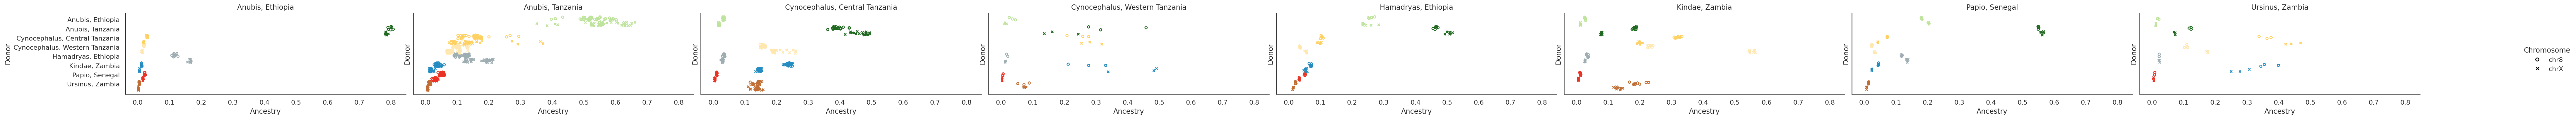

In [91]:
input_data = df_length_stats_8
input_data.chrom = input_data.chrom.astype("category")
input_data["Population, Donor"] = input_data["Population, Donor"].astype("category")

palette_subset = {key: color_dir[key] for key in sorted(input_data["Population, Donor"].unique())}
palette = sns.color_palette(palette_subset.values())
markers = {'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Recipient", hue="chrom", data=input_data,
                      margin_titles=True, legend_out=True, aspect=2.5)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
    # axix labels and rotated labels (this has to be in a separate for-loop)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")

    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr8", "chrX"])
plt.savefig("../figures/baboon_ancestry/ancestry_8pop.png", dpi=300, bbox_inches='tight')

In [92]:
df_length_stats_38X = pd.concat([df_length_stats_8, df_length_stats_3])

In [93]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
idfile_8 = idfile.loc[idfile.PGDP_ID.isin(df_length_stats_38X.individual)]
color_8 = sns.color_palette(["#BEE39C", "#1F681F", "#FFE7AF",
                            "#FFD062", "#9EADB2", "#258CC1", "#EA3324", "#C06D34"])

name_order = ['Olive Gog', 'Olive South', 'Yellow East', 'Yellow West',
       'Hamadryas', 'Kinda', 'Guinea',
       'Chacma']
i_order = sorted(df_length_stats_3["Population, Recipient"].unique())
p_map = {}
for i in range(len(i_order)):
    p_map[i_order[i]] = name_order[i]
l_list = sorted(idfile_8["pop"].unique())
dict_8 = {}
color_dir_8 = {}
for i in range(len(l_list)):
    dict_8[l_list[i]] = name_order[i]
    color_dir_8[name_order[i]] = color_8[i]

In [94]:
df_length_stats_38X["Population, Donor"] = df_length_stats_38X["Population, Donor"].map(p_map)
df_length_stats_38X["Population, Recipient"] = df_length_stats_38X["Population, Recipient"].map(p_map)

/home/eriks/miniconda3/envs/geo_env/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


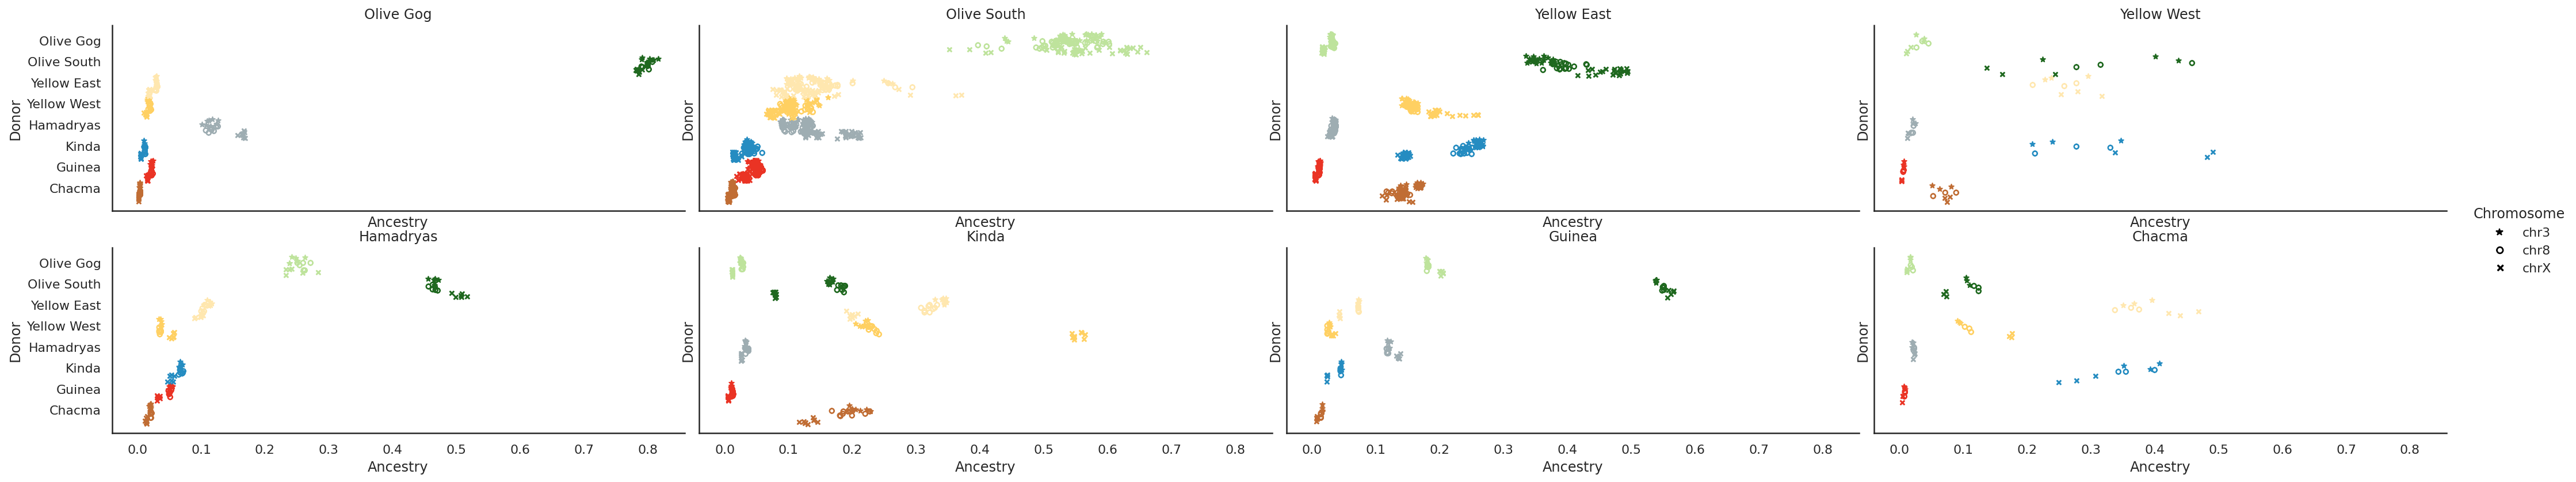

In [95]:
input_data = df_length_stats_38X
input_data.chrom = input_data.chrom.astype("category")
input_data["Population, Donor"] = input_data["Population, Donor"].astype("category")
input_data["Population, Donor"] = input_data["Population, Donor"].cat.reorder_categories(name_order)

palette_subset = {key: color_dir_8[key] for key in input_data["Population, Donor"].unique()}
palette = sns.color_palette(palette_subset.values())

palette_subset = {key: color_dir_8[key] for key in name_order}
palette = sns.color_palette(palette_subset.values())
markers = {'chr3': "*", 'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Recipient", hue="chrom", data=input_data,
                      margin_titles=True, legend_out=True, aspect=2.5, col_wrap=4)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
    # axix labels and rotated labels (this has to be in a separate for-loop)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")

    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr3", "chr8", "chrX"])
plt.subplots_adjust(hspace = 0.2)
plt.savefig("../figures/baboon_ancestry/ancestry_chr3_8pop.png", dpi=300, bbox_inches='tight')

In [96]:
df_length_stats_8["Population, Donor"] = df_length_stats_8["Population, Donor"].map(p_map)
df_length_stats_8["Population, Recipient"] = df_length_stats_8["Population, Recipient"].map(p_map)

/home/eriks/miniconda3/envs/geo_env/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


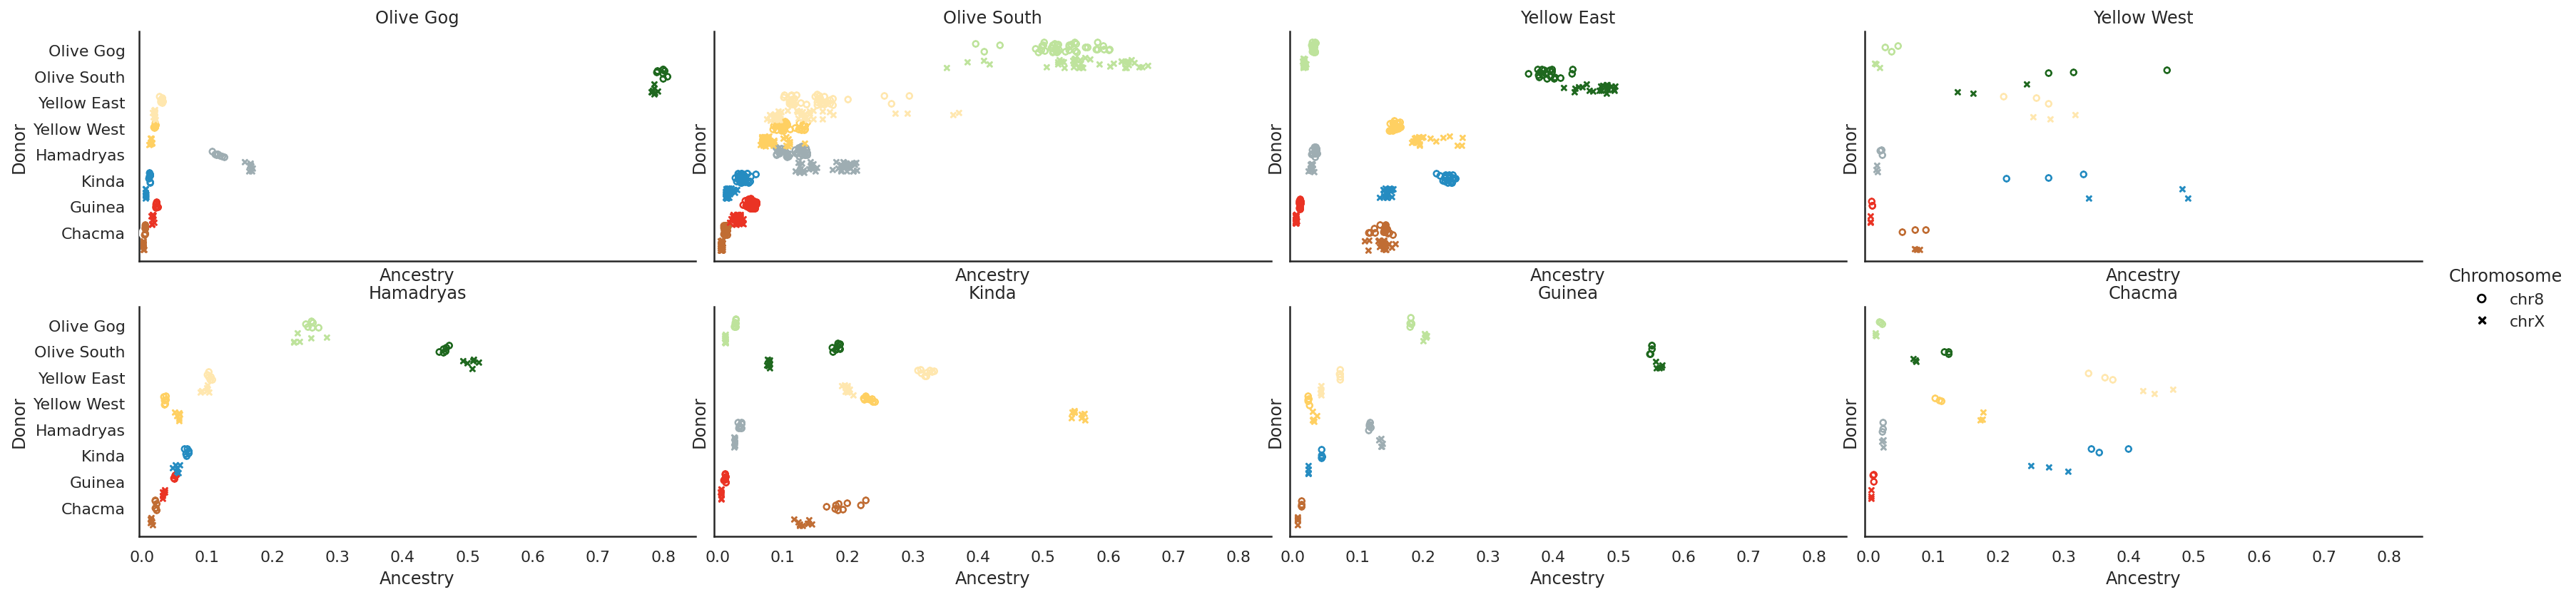

In [97]:
order_all = ['Hamadryas', 'Guinea','Kinda', 'Chacma',
    'Olive Gog', 'Olive South', 'Yellow East', 'Yellow West']
input_data = df_length_stats_8
input_data.chrom = input_data.chrom.astype("category")
input_data["Population, Donor"] = input_data["Population, Donor"].astype("category")
input_data["Population, Donor"] = input_data["Population, Donor"].cat.reorder_categories(name_order)

palette_subset = {key: color_dir_8[key] for key in name_order}
palette = sns.color_palette(palette_subset.values())
markers = {'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Recipient", hue="chrom", data=input_data,
                      margin_titles=True, legend_out=True, height=3, aspect=2, col_wrap=4)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
        g.set(xlim=(-0.005, 0.85))
    # axix labels and rotated labels (this has to be in a separate for-loop)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")

    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr8", "chrX"])
plt.subplots_adjust(hspace = 0.2)
plt.savefig("../figures/baboon_ancestry/ancestry_8pop.png", dpi=300, bbox_inches='tight')

/home/eriks/miniconda3/envs/geo_env/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-98-64905c9ae72b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].astype("category")
<ipython-input-98-64905c9ae72b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

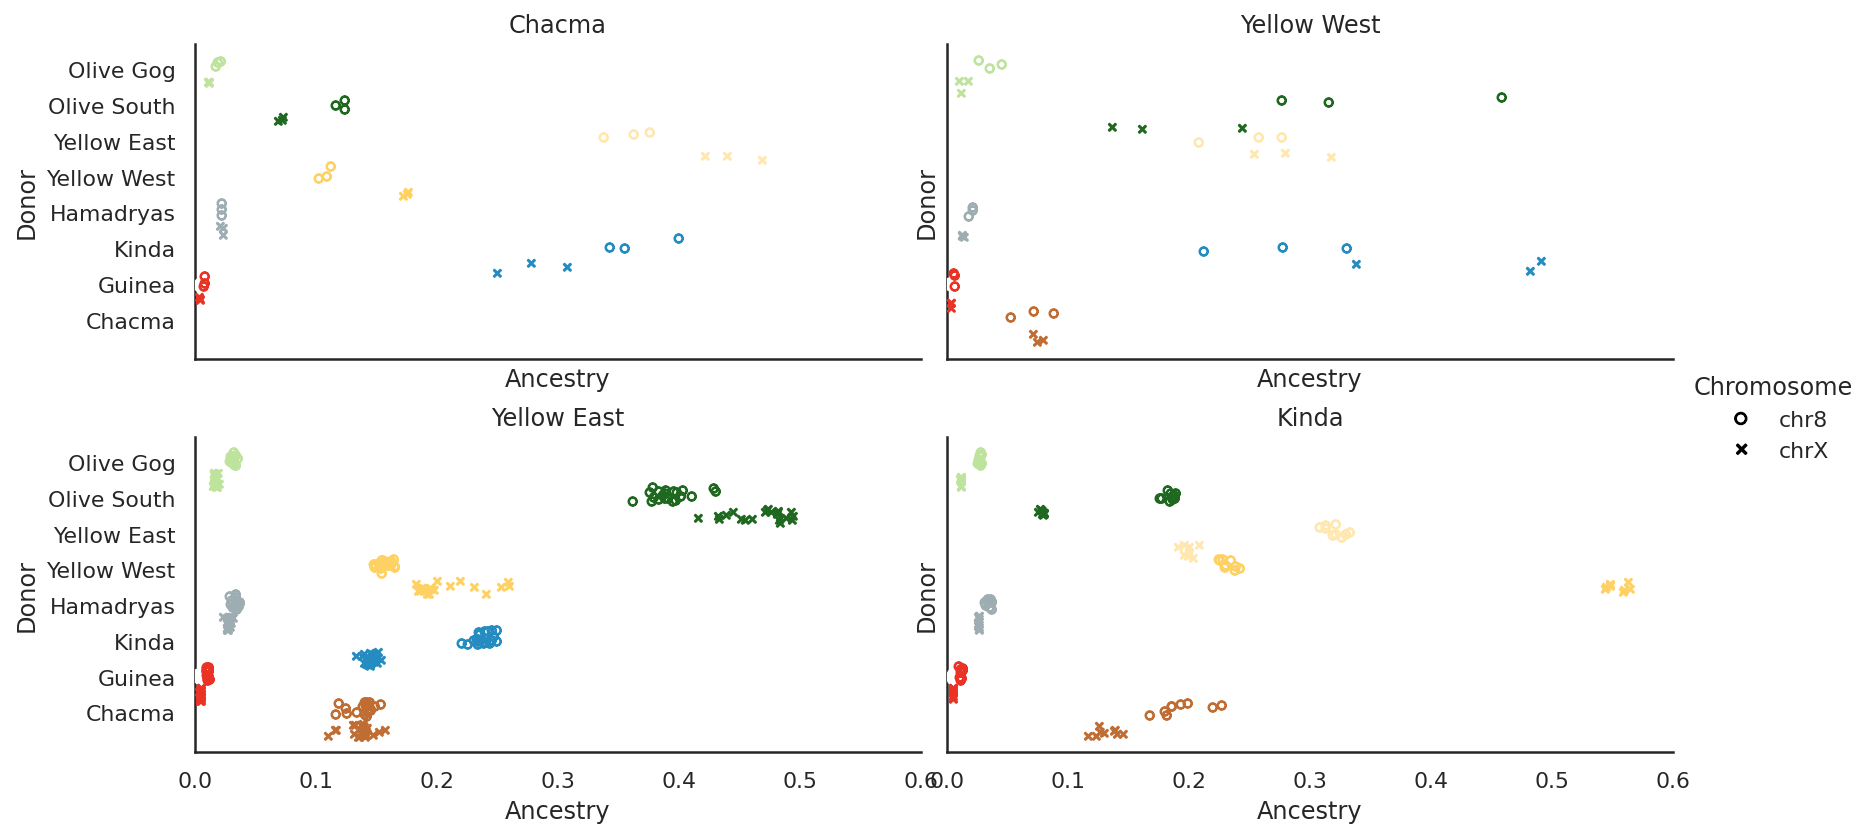

In [98]:
order_all = ['Chacma', 'Yellow West', 'Yellow East', 'Kinda']

input_data_sub = (df_length_stats_8.loc[df_length_stats_8["Population, Recipient"].isin(order_all)])
input_data_sub.chrom = input_data_sub.chrom.astype("category")
input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].astype("category")
input_data_sub["Population, Recipient"] = input_data_sub["Population, Recipient"].astype("category")
input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].cat.remove_unused_categories()

palette_subset = {key: color_dir_8[key] for key in name_order}
palette = sns.color_palette(palette_subset.values())
markers = {'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Recipient", hue="chrom", data=input_data_sub,
                      margin_titles=True, legend_out=True, height=3, aspect=2, col_wrap=2, col_order = order_all)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
        g.set(xlim=(0, 0.6))
    # axix labels and rotated labels (this has to be in a separate for-loop)
    #plt.subplots_adjust(hspace=0.2, wspace=0.1)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")
    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr8", "chrX"])
plt.subplots_adjust(hspace = 0.25)
plt.savefig("../figures/baboon_ancestry/ancestry_8pop_main_subset.pdf", dpi=300, bbox_inches='tight')

/home/eriks/miniconda3/envs/geo_env/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-99-530494274e9b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].astype("category")
<ipython-input-99-530494274e9b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

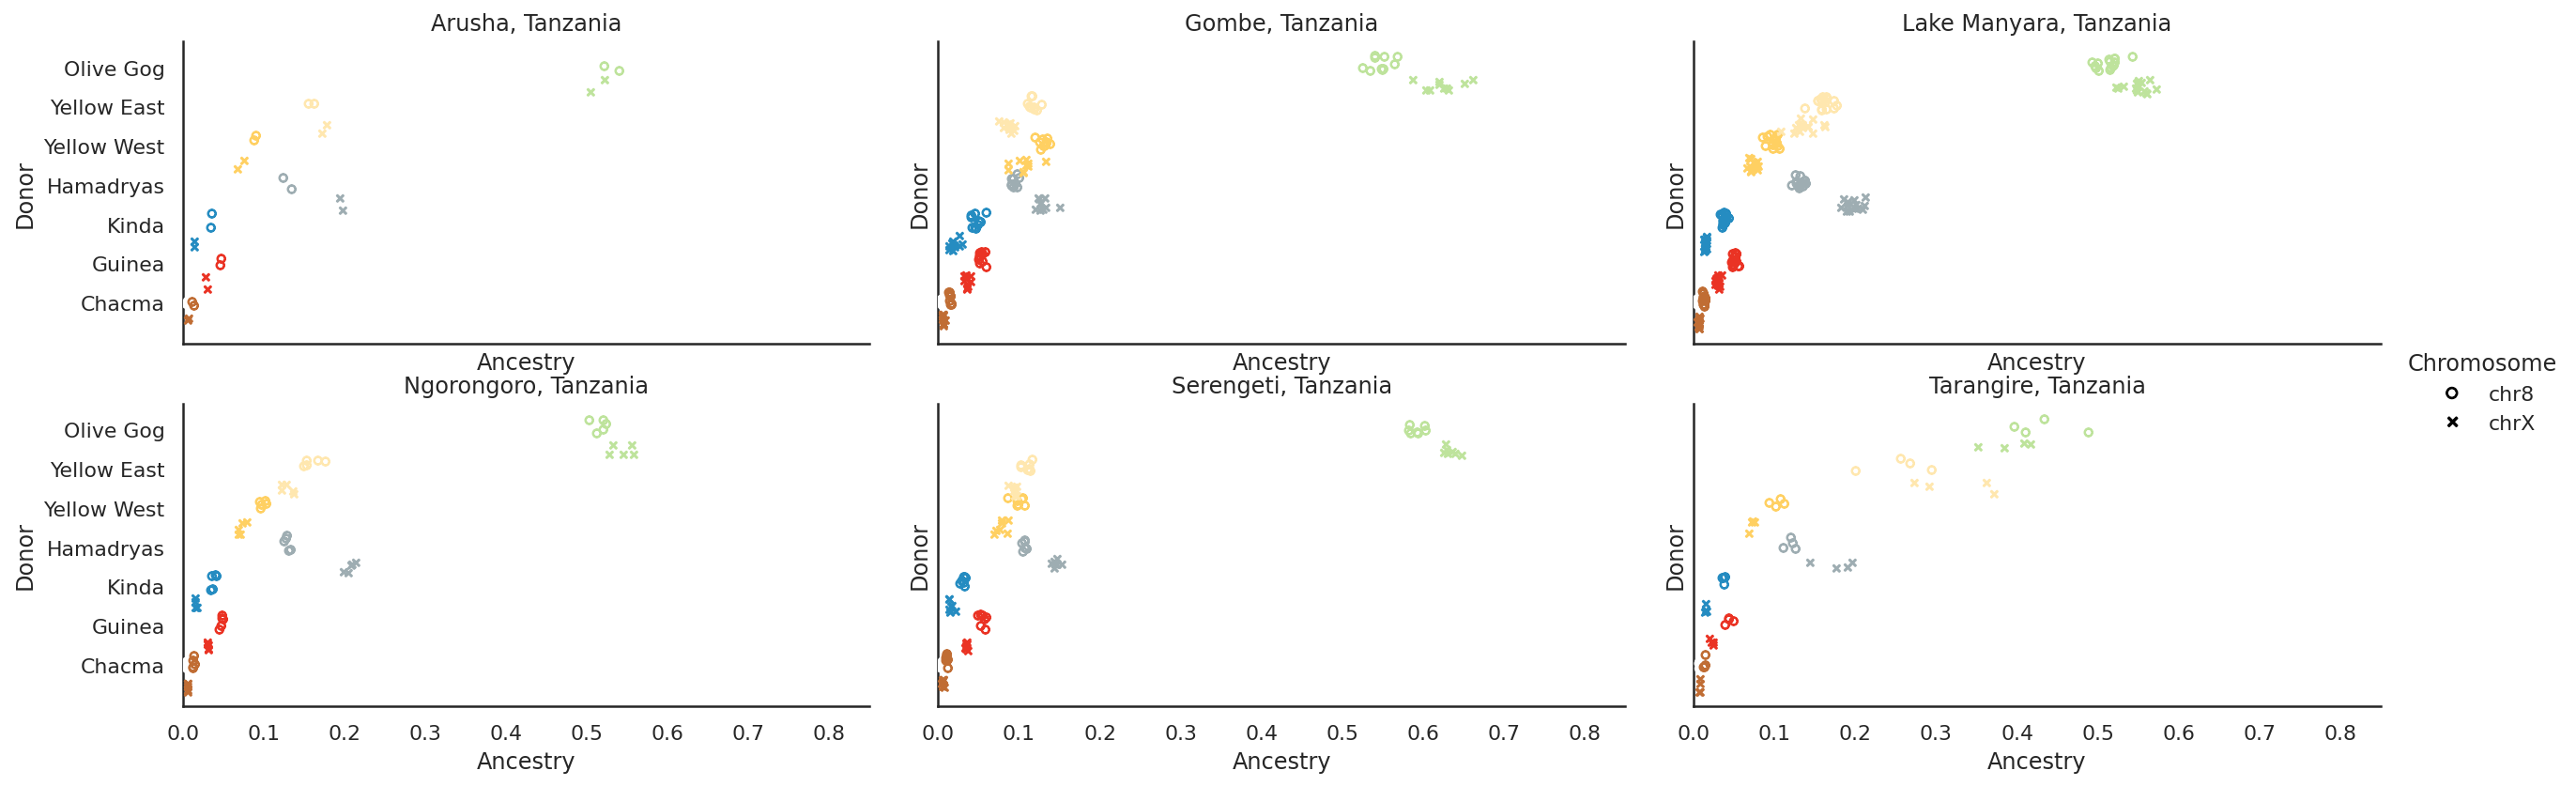

In [99]:
order_all = ['Olive South']
 
input_data_sub = (df_length_stats_8.loc[df_length_stats_8["Population, Recipient"].isin(order_all)])
input_data_sub.chrom = input_data_sub.chrom.astype("category")
input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].astype("category")
input_data_sub["Population, Location"] = input_data_sub["population"].astype("category")
input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].cat.remove_unused_categories()

palette_subset = {key: color_dir_8[key] for key in input_data_sub["Population, Donor"].unique()}
palette = sns.color_palette(palette_subset.values())
markers = {'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Location", hue="chrom", data=input_data_sub,
                      margin_titles=True, legend_out=True, height=3, aspect=2, col_wrap=3)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
        g.set(xlim=(0, 0.85))
    # axix labels and rotated labels (this has to be in a separate for-loop)
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")
    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr8", "chrX"])
plt.subplots_adjust(hspace = 0.2)
plt.savefig("../figures/baboon_ancestry/ancestry_8pop_anubis_samples.png", dpi=300, bbox_inches='tight')

/home/eriks/miniconda3/envs/geo_env/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-100-009b91434fa7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].astype("category")
<ipython-input-100-009b91434fa7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

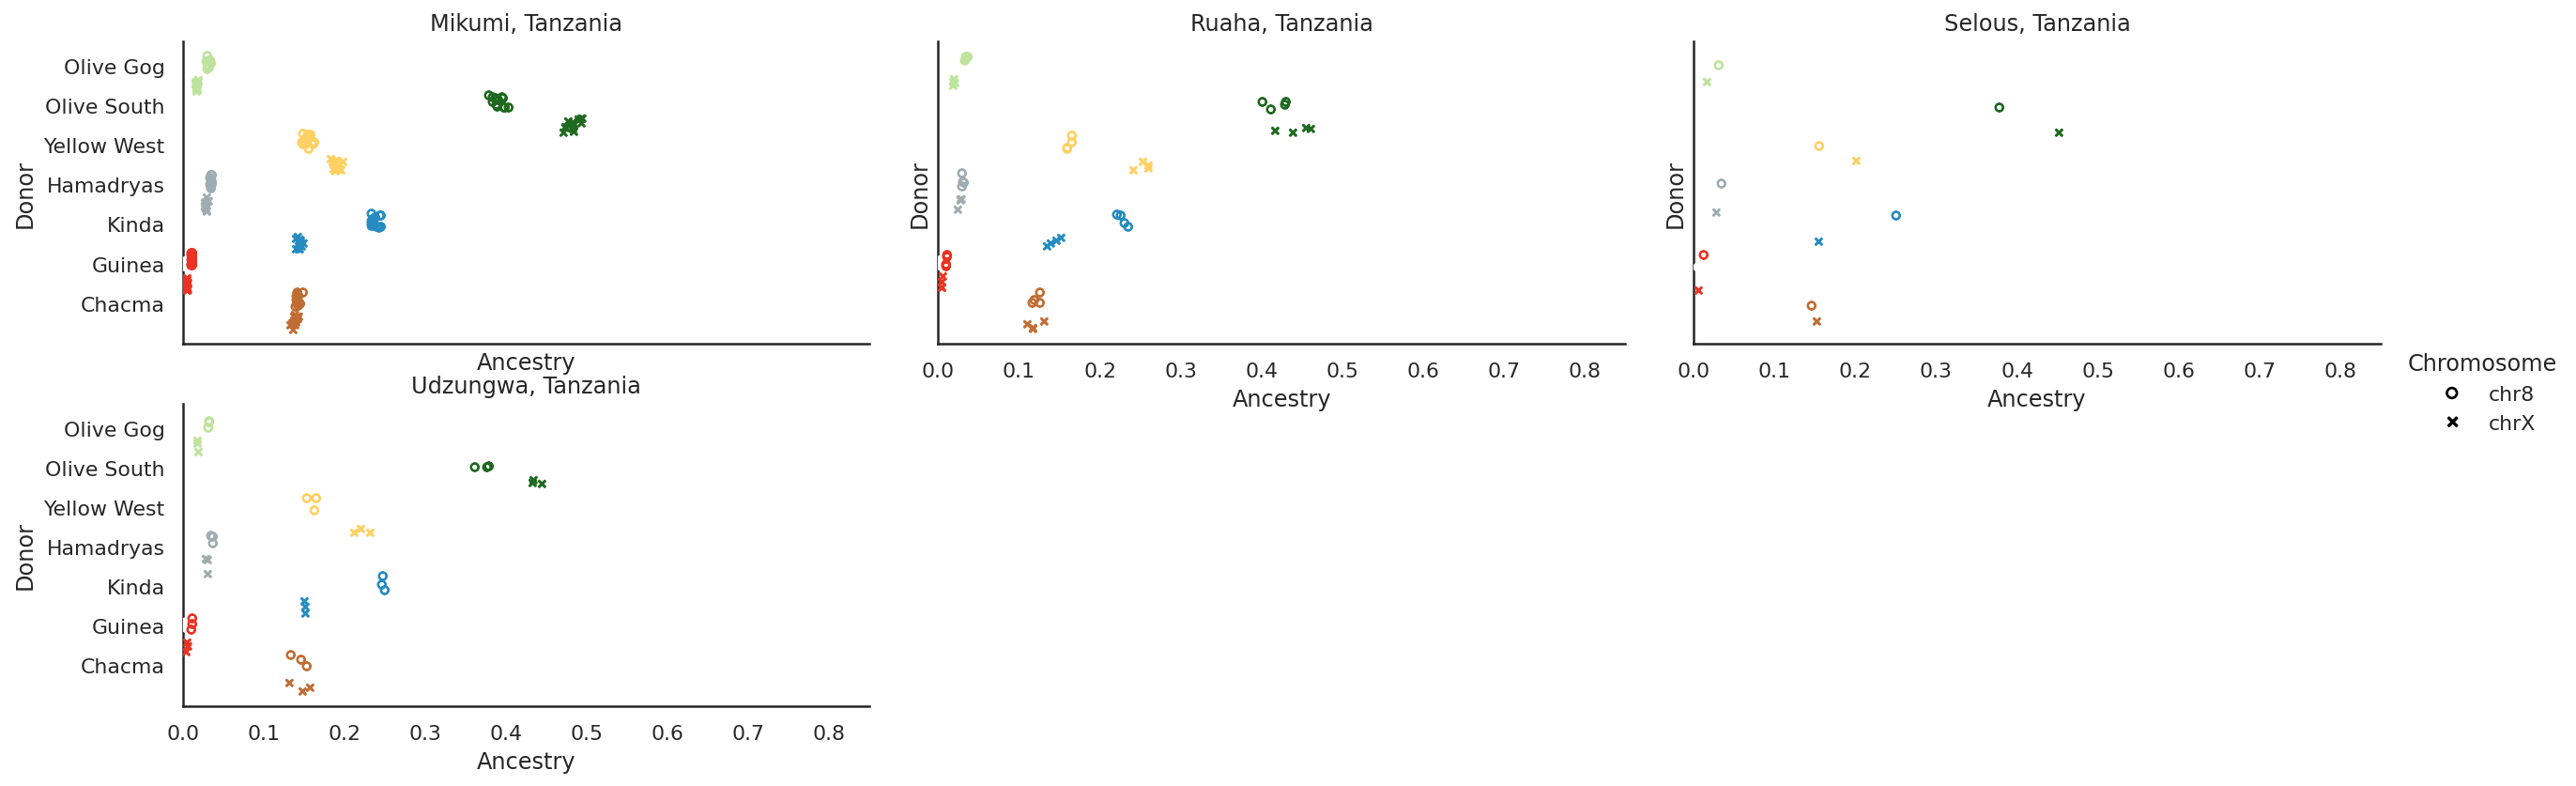

In [100]:
order_all = ['Yellow East']
 
input_data_sub = (df_length_stats_8.loc[df_length_stats_8["Population, Recipient"].isin(order_all)])
input_data_sub.chrom = input_data_sub.chrom.astype("category")
input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].astype("category")
input_data_sub["Population, Location"] = input_data_sub["population"].astype("category")
input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].cat.remove_unused_categories()

palette_subset = {key: color_dir_8[key] for key in input_data_sub["Population, Donor"].unique()}
palette = sns.color_palette(palette_subset.values())
markers = {'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Location", hue="chrom", data=input_data_sub,
                      margin_titles=True, legend_out=True, height=3, aspect=2, col_wrap=3)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
        g.set(xlim=(0, 0.85))
    # axix labels and rotated labels (this has to be in a separate for-loop)
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")
    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr8", "chrX"])
plt.subplots_adjust(hspace = 0.2)
plt.savefig("../figures/baboon_ancestry/ancestry_8pop_yellow_east_samples.png", dpi=300, bbox_inches='tight')

/home/eriks/miniconda3/envs/geo_env/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-101-c1f4bf47329d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].astype("category")
<ipython-input-101-c1f4bf47329d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

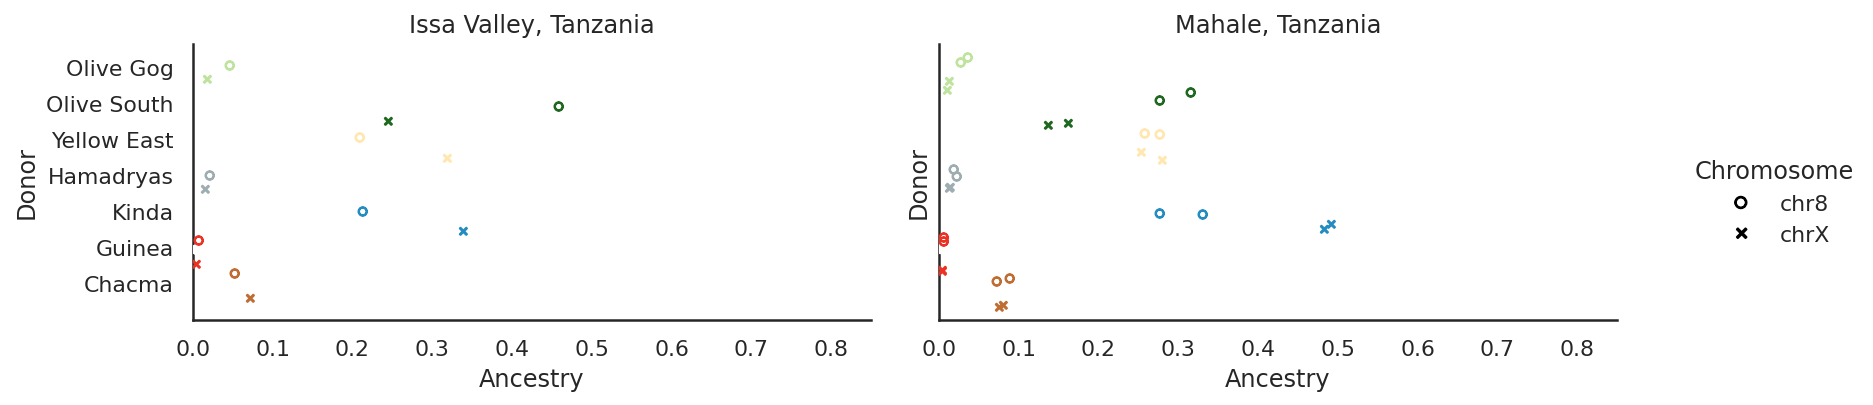

In [101]:
order_all = ['Yellow West']

input_data_sub = (df_length_stats_8.loc[df_length_stats_8["Population, Recipient"].isin(order_all)])
input_data_sub.chrom = input_data_sub.chrom.astype("category")
input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].astype("category")
input_data_sub["Population, Location"] = input_data_sub["population"].astype("category")
input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].cat.remove_unused_categories()

palette_subset = {key: color_dir_8[key] for key in input_data_sub["Population, Donor"].unique()}
palette = sns.color_palette(palette_subset.values())
markers = {'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Location", hue="chrom", data=input_data_sub,
                      margin_titles=True, legend_out=True, height=3, aspect=2)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
        g.set(xlim=(0, 0.85))
    # axix labels and rotated labels (this has to be in a separate for-loop)
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")
    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr8", "chrX"])
plt.subplots_adjust(hspace = 0.2)
plt.savefig("../figures/baboon_ancestry/ancestry_8pop_yellow_west_samples.png", dpi=300, bbox_inches='tight')

7 cluster

In [102]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_7_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chr{}/chr{}.females.recombfile"

os.makedirs("../steps/paint_summary/", exist_ok=True)
chrom_list = [] #["8", "X"] # ["X"]
window_length = 100000
df_l = []
for chrom in chrom_list:
    recomb_map = pd.read_csv(recomb_map_path.format(chrom, chrom), sep=" ")
    pos_list = recomb_map["start.pos"]
    for population in ["cyno_anubis_t"]:
        print(population)
        pop_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/" \
                        "chr{}_7_cluster_large/{}_chr{}_7_cluster_large/chr{}.samples.out"\
                        .format(chrom, population, chrom, chrom)
        length_df = create_paint_df_lengths(pop_path, idfile)
        length_df["chrom"] = chrom
        length_df["C_origin"] = population
        df_l.append(length_df)
#df_lengths_7 = pd.concat(df_l)

In [103]:
#df_lengths_7.to_csv("../steps/paint_summary/"+"paint_lengths_7_cluster.txt", sep=" ", index=False)
df_lengths_7 = pd.read_csv("../steps/paint_summary/"+"paint_lengths_7_cluster.txt", sep=" ")

/home/eriks/miniconda3/envs/geo_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Transformations to rename columns and calculate mean ancestry

In [104]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
mapping = {}
c_mapping = {}
for i, row in meta_data_samples.iterrows():
    if row.PGDP_ID[0] != "P":
        mapping["Sci_"+row.PGDP_ID] = row.Origin
        c_mapping["Sci_"+row.PGDP_ID] = row.C_origin
    else:
        mapping[row.PGDP_ID] = row.Origin
        c_mapping[row.PGDP_ID] = row.C_origin
df_lengths_7["population"] = df_lengths_7["individual"].map(mapping)
df_lengths_7["C_origin"] = df_lengths_7["individual"].map(c_mapping)
df_lengths_7["chrom"] = ["chr{}".format(x) if str(x)[0] != "c" else x for x in df_lengths_7.chrom]

In [105]:
id_mapping = {}
for donor in idfile["pop"].unique():
    IDs = idfile.loc[idfile["pop"] == donor].PGDP_ID.unique()
    id_mapping[donor] = meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(IDs)].C_origin.unique()[0]

In [106]:
df_length_stats_7 = df_lengths_7.groupby(["individual", "pop", "C_origin", "chrom"]).sum().reset_index()
df_length_stats_7["Ancestry Counts"] = (df_length_stats_7.groupby(["individual", "pop", "C_origin", "chrom"]).count().reset_index()).paint_length
df_length_stats_7["Mean Fragment"] = (df_length_stats_7.groupby(["individual", "pop", "C_origin", "chrom"]).mean().reset_index()).paint_length

In [107]:
groups = df_length_stats_7.groupby(["individual", "chrom"])
s = groups.transform("sum")
df_length_stats_7["Ancestry Percentage"] = df_length_stats_7["paint_length"]/s["paint_length"]
df_length_stats_7["Fragment Percentage"] = df_length_stats_7["Ancestry Counts"]/s["Ancestry Counts"]

In [108]:
df_length_stats_7["population"] = df_length_stats_7["individual"].map(mapping)
df_length_stats_7["Population, Donor"] = df_length_stats_7["pop"].map(id_mapping)
df_length_stats_7["Population, Recipient"] = df_length_stats_7["individual"].map(c_mapping)
df_length_stats_7 = df_length_stats_7.sort_values(["population", "individual", "pop"])
df_length_stats_7["Ancestry Fragment Ratio"] = df_length_stats_7["Ancestry Percentage"]/df_length_stats_7["Fragment Percentage"]

In [109]:
df_length_stats_7["Population, Donor"] = df_length_stats_7["Population, Donor"].map(p_map)
df_length_stats_7["Population, Recipient"] = df_length_stats_7["Population, Recipient"].map(p_map)

In [110]:
order_6 = ['Olive Gog', 'Yellow West', 
       'Hamadryas', 'Kinda', 'Guinea',
       'Chacma']

/home/eriks/miniconda3/envs/geo_env/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


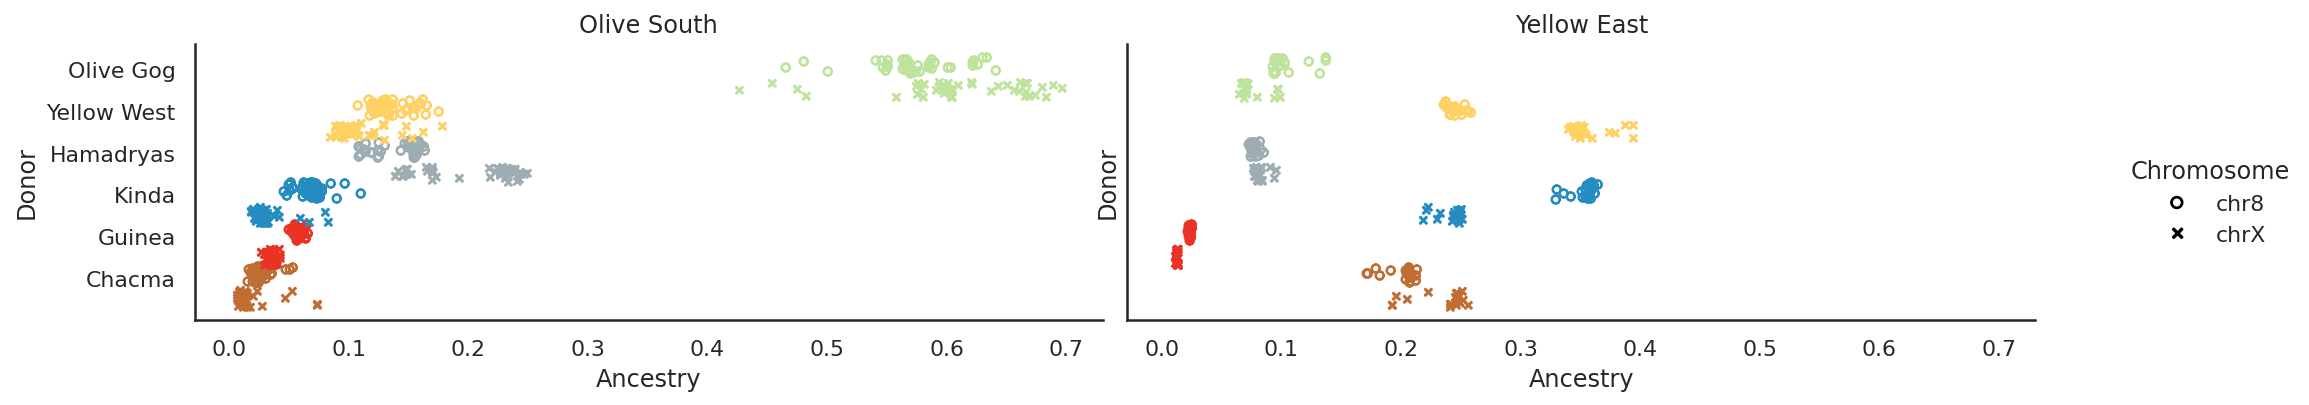

In [111]:
input_data = df_length_stats_7
input_data.chrom = input_data.chrom.astype("category")
input_data["Population, Donor"] = input_data["Population, Donor"].astype("category")
input_data["Population, Donor"] = input_data["Population, Donor"].cat.reorder_categories(order_6)

palette_subset = {key: color_dir_8[key] for key in input_data["Population, Donor"].unique()}
palette = sns.color_palette(palette_subset.values())
markers = {'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Recipient", hue="chrom", data=input_data,
                      margin_titles=True, legend_out=True, aspect=2.5)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
    # axix labels and rotated labels (this has to be in a separate for-loop)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")

    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr8", "chrX"])
plt.savefig("../figures/baboon_ancestry/ancestry_tanzania_7pop.png", dpi=300, bbox_inches='tight')

Checking the yellow females

Empty legends for Globetrotter

In [45]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_14_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
idfile_14 = idfile.loc[idfile.PGDP_ID.isin(df_length_stats_38X.individual)]
color_14 = sns.color_palette(["#BEE39C", "#88ad00", "#3BAC3B", "#68E068", "#77c458", "#1F681F",
                            "#FFBD00", "#FFD062", "#ebc97a", "#FFDE90",
                            "#9EADB2", "#258CC1", "#EA3324", "#C06D34"])

name_order = ['Olive Gog', 'Gombe', 'Lake Manyara', 'Ngorongoro and Arusha', 'Serengeti', 'Tarangire',
              'Mikumi', 'Udzungwa and Selous', 'Ruaha','Yellow West',
           'Hamadryas', 'Kinda', 'Guinea ', 'Chacma']

l_list = sorted(idfile_14["pop"].unique())
dict_14 = {}
color_dir_14 = {}
for i in range(len(l_list)):
    dict_14[l_list[i]] = name_order[i]
    color_dir_14[name_order[i]] = color_14[i]

In [46]:
color_14

[(0.7450980392156863, 0.8901960784313725, 0.611764705882353),
 (0.5333333333333333, 0.6784313725490196, 0.0),
 (0.23137254901960785, 0.6745098039215687, 0.23137254901960785),
 (0.40784313725490196, 0.8784313725490196, 0.40784313725490196),
 (0.4666666666666667, 0.7686274509803922, 0.34509803921568627),
 (0.12156862745098039, 0.40784313725490196, 0.12156862745098039),
 (1.0, 0.7411764705882353, 0.0),
 (1.0, 0.8156862745098039, 0.3843137254901961),
 (0.9215686274509803, 0.788235294117647, 0.47843137254901963),
 (1.0, 0.8705882352941177, 0.5647058823529412),
 (0.6196078431372549, 0.6784313725490196, 0.6980392156862745),
 (0.1450980392156863, 0.5490196078431373, 0.7568627450980392),
 (0.9176470588235294, 0.2, 0.1411764705882353),
 (0.7529411764705882, 0.42745098039215684, 0.20392156862745098)]

In [47]:
idfile_14["name_14"] = idfile_14["pop"].map(dict_14)
idfile_14["color"] = idfile_14["name_14"].map(color_dir_14)
cluster_color = pd.Series(idfile_14["color"].values,index=idfile_14["PGDP_ID"]).to_dict()

<ipython-input-47-8f6b1d75a783>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idfile_14["name_14"] = idfile_14["pop"].map(dict_14)
<ipython-input-47-8f6b1d75a783>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idfile_14["color"] = idfile_14["name_14"].map(color_dir_14)


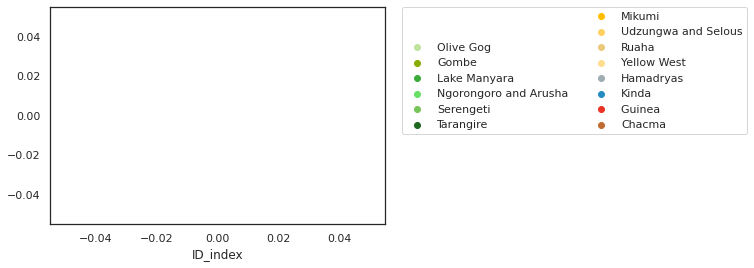

In [48]:
sns.scatterplot(data=idfile_14.sort_values(["name_14"]), x="ID_index", hue="name_14",
                palette=color_dir_14, hue_order=name_order)
plt.plot(np.zeros([1,2]), color='w', alpha=0, label=' ')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 2)
plt.savefig("../figures/14pop_legend.pdf", dpi=300, bbox_inches='tight')

In [49]:
name_order

['Olive Gog',
 'Gombe',
 'Lake Manyara',
 'Ngorongoro and Arusha',
 'Serengeti',
 'Tarangire',
 'Mikumi',
 'Udzungwa and Selous',
 'Ruaha',
 'Yellow West',
 'Hamadryas',
 'Kinda',
 'Guinea ',
 'Chacma']

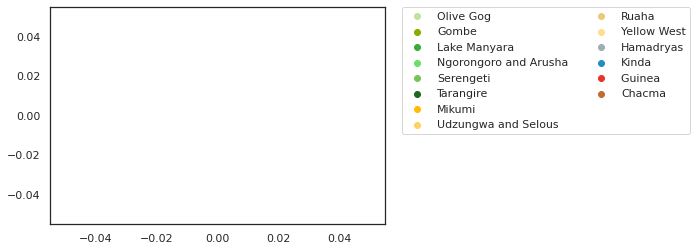

In [50]:
for name in name_order:
    plt.scatter(np.arange(0), np.random.random([0,1]), color=color_dir_14[name], label=name)
plt.scatter(np.zeros(1), np.zeros([1,1]), color='w', alpha=0, label=' ')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 2)
plt.savefig("../figures/14pop_legend.pdf", dpi=300, bbox_inches='tight')

In [51]:
idfile_8["name_8"] = idfile_8["pop"].map(dict_8)
idfile_8["color"] = idfile_8["name_8"].map(color_dir_8)
cluster_color = pd.Series(idfile_14["color"].values,index=idfile_14["PGDP_ID"]).to_dict()
name_order = ['Olive Gog', 'Olive South', 'Yellow East', 'Yellow West',
       'Hamadryas', 'Kinda', 'Guinea',
       'Chacma']

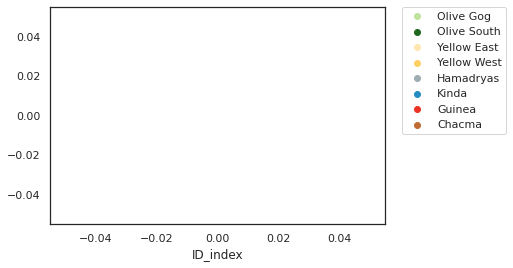

In [52]:
sns.scatterplot(data=idfile_8.sort_values(["name_8"]), x="ID_index", hue="name_8",
                palette=color_dir_8, hue_order=name_order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("../figures/8pop_legend.pdf", dpi=300, bbox_inches='tight')

Using the viterbi samples

In [59]:
#Functions to generate the stacked area plot df

#Should be easily extendable to multiple paintings by repeating the loop
def length_to_windows(length_df, window_size=100000):
    pops = sorted(length_df["pop"].unique())
    window_l = list(range(length_df.pos.values[0], length_df.end_pos.values[-1], window_size))
    overall_dict = {"windows": window_l}
    for p in pops:
        overall_dict[p] = np.zeros(len(window_l))
    for i in range(len(window_l)):
        w = window_l[i]
        # Finding all paintings that start in this window.
        s_df = length_df.loc[(length_df.pos >= w) & (length_df.pos < w+window_size)]
        for index, row in s_df.iterrows():
            # x decides how many windows it should go beyond the current.
            # if x==0, it both starts and ends in the same window
            x = (row.pos-w+row.paint_length)//window_size
            if x == 0:
                overall_dict[row["pop"]][i] += int(row.paint_length)
            # Otherwise, the current window is filled from row.pos to window end
            else:
                overall_dict[row["pop"]][i] += int((w+window_size)-row.pos)
                # Then iterated for each full window (which is all windows < x)
                for s in range(x-1):
                    overall_dict[row["pop"]][i+1+s] += int(window_size)
                # Then finally added the ending window
                # print(row.paint_length+row.pos, (w+x*window_size), x, w)
                overall_dict[row["pop"]][i+x] += int(row.paint_length+row.pos-(w+x*window_size))
    df = pd.DataFrame(overall_dict)
    return df

def generate_spot_df(single_p_df, map_dict):
    single_p_df["pop"] = single_p_df["paint"].map(map_dict)
    shift_spots = (single_p_df["pop"] != single_p_df["pop"].shift())
    #df based on this subset
    spot_df = single_p_df.loc[shift_spots].copy()
    #Finding the start of the next painting, by removing the first pos and adding the last snp.
    #And then calculating the difference.
    spot_df["paint_length"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-spot_df["pos"].values)
    spot_df["end_pos"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-1)
    return spot_df

def create_paint_df_lengths(paintfile, idfile, haploid=False):
    #various supplemental dataframes/lists
    end_pos = pos_list.values[-1]
    
    map_dict = {}
    if haploid==False:
        h = 2
    else:
        h = 1
    for i, row in idfile.iterrows():
        map_dict[row.ID_index*h+1] = row["pop"]
        map_dict[row.ID_index*h+2] = row["pop"]

    df_l = []
    f = open(paintfile, "r")
    ad_lines = f.readlines()
    ind = ""
    hap = ""
    sample = 0
    for p_num in range(1, len(ad_lines)):
        l = ad_lines[p_num].strip().split(" ")
        if l[0] == "HAP":
            ind = l[2]
            sample = 0
            if haploid==False:
                if hap == 1:
                    hap = 2
                else:
                    hap = 1
            else:
                hap = 1
        else:
            paint_line = l[1:]
            single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
            single_p_df = single_p_df.astype(int)
            spot_df = generate_spot_df(single_p_df, map_dict)
            sample += 1
            spot_df["sample"] = sample
            spot_df["individual"] = ind
            spot_df["haplotype"] = hap
            df_l.append(spot_df)
    all_df = pd.concat(df_l)
    return all_df

In [85]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chr{}/chr{}.females.recombfile"

os.makedirs("../steps/paint_summary/", exist_ok=True)
chrom_list = [] #["8", "X"] # ["X"]
window_length = 100000
df_l = []
for chrom in chrom_list:
    recomb_map = pd.read_csv(recomb_map_path.format(chrom, chrom), sep=" ")
    pos_list = recomb_map["start.pos"]
    for population in sorted(idfile["pop"].unique()):
        print(population)
        pop_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/" \
                        "chr{}_8_cluster_large/{}_chr{}_8_cluster_large/chr{}.samples.out"\
                        .format(chrom, population, chrom, chrom)
        length_df = create_paint_df_lengths(pop_path, idfile)
        length_df["chrom"] = chrom
        length_df["C_origin"] = population
        length_df.to_csv("../steps/paint_summary/"+population+"_chr"+chrom+"_viterbi_df.txt", sep=" ", index=False)
        df_l.append(length_df)
length_df_viterbi = pd.concat(df_l)

anubis_ethiopia
anubis_tanzania
cyno_central
cyno_western
hamadryas
kindae
papio
ursinus
anubis_ethiopia
anubis_tanzania
cyno_central
cyno_western
hamadryas
kindae
papio
ursinus


In [3]:
#length_df_viterbi.to_csv("../steps/paint_summary/"+"df_length_stats_viterbi", sep=" ", index=False)
length_df_viterbi = pd.read_csv("../steps/paint_summary/"+"df_length_stats_viterbi", sep=" ")

/home/eriks/miniconda3/envs/geo_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
mapping = {}
c_mapping = {}
for i, row in meta_data_samples.iterrows():
    if row.PGDP_ID[0] != "P":
        mapping["Sci_"+row.PGDP_ID] = row.Origin
        c_mapping["Sci_"+row.PGDP_ID] = row.C_origin
    else:
        mapping[row.PGDP_ID] = row.Origin
        c_mapping[row.PGDP_ID] = row.C_origin
length_df_viterbi["population"] = length_df_viterbi["individual"].map(mapping)
length_df_viterbi["C_origin"] = length_df_viterbi["individual"].map(c_mapping)
length_df_viterbi["chrom"] = ["chr{}".format(x) if str(x)[0] != "c" else x for x in length_df_viterbi.chrom]

In [11]:
id_mapping = {}
for donor in idfile["pop"].unique():
    IDs = idfile.loc[idfile["pop"] == donor].PGDP_ID.unique()
    id_mapping[donor] = meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(IDs)].C_origin.unique()[0]
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
idfile_8 = idfile.loc[idfile.PGDP_ID.isin(length_df_viterbi.individual)]
color_8 = sns.color_palette(["#BEE39C", "#1F681F", "#FFE7AF",
                            "#FFD062", "#9EADB2", "#258CC1", "#EA3324", "#C06D34"])

name_order = ['Olive Gog', 'Olive South', 'Yellow East', 'Yellow West',
       'Hamadryas', 'Kinda', 'Guinea', 'Chacma']
i_order = sorted(length_df_viterbi["C_origin"].unique())
p_map = {}
for i in range(len(i_order)):
    p_map[i_order[i]] = name_order[i]
l_list = sorted(idfile_8["pop"].unique())
dict_8 = {}
color_dir_8 = {}
for i in range(len(l_list)):
    dict_8[l_list[i]] = name_order[i]
    color_dir_8[name_order[i]] = color_8[i]

In [26]:
df_lengths = length_df_viterbi
df_total_stats = df_lengths.groupby(["individual", "C_origin", "chrom", "sample"]).mean().reset_index()
df_total_stats = df_lengths.groupby(["individual", "C_origin", "chrom", "sample"]).mean().reset_index()
df_length_stats = df_lengths.groupby(["individual", "pop", "C_origin", "chrom", "sample"]).sum().reset_index()
df_length_stats["Ancestry Counts"] = (df_lengths.groupby(["individual", "pop", "C_origin", "chrom", "sample"]).count().reset_index()).paint_length
df_length_stats["Mean Fragment"] = (df_lengths.groupby(["individual", "pop", "C_origin", "chrom", "sample"]).mean().reset_index()).paint_length
groups = df_length_stats.groupby(["individual", "chrom", "sample"])
s = groups.transform("sum")
df_length_stats["Ancestry Percentage"] = df_length_stats["paint_length"]/s["paint_length"]
df_length_stats["Fragment Percentage"] = df_length_stats["Ancestry Counts"]/s["Ancestry Counts"]
df_length_stats["population"] = df_length_stats["individual"].map(mapping)
df_length_stats["Population, Donor"] = df_length_stats["pop"].map(id_mapping)
df_length_stats["Population, Recipient"] = df_length_stats["individual"].map(c_mapping)
df_length_stats = df_length_stats.sort_values(["population", "individual", "pop", "chrom"])
df_length_stats["Ancestry Fragment Ratio"] = df_length_stats["Ancestry Percentage"]/df_length_stats["Fragment Percentage"]
length_df_viterbi_stats = df_length_stats

In [28]:
length_df_viterbi_stats["Population, Donor"] = length_df_viterbi_stats["Population, Donor"].map(p_map)
length_df_viterbi_stats["Population, Recipient"] = length_df_viterbi_stats["Population, Recipient"].map(p_map)

In [3]:
#length_df_viterbi_stats.to_csv("../steps/paint_summary/"+"length_df_viterbi_stats", sep=" ", index=False)
length_df_viterbi_stats = pd.read_csv("../steps/paint_summary/"+"length_df_viterbi_stats", sep=" ")

In [5]:
order_all = ['Hamadryas', 'Guinea','Kinda', 'Chacma',
    'Olive Gog', 'Olive South', 'Yellow East', 'Yellow West']
name_order = ['Olive Gog', 'Olive South', 'Yellow East', 'Yellow West',
       'Hamadryas', 'Kinda', 'Guinea', 'Chacma']

input_data = length_df_viterbi_stats
input_data.chrom = input_data.chrom.astype("category")
input_data["Population, Donor"] = input_data["Population, Donor"].astype("category")
input_data["Population, Donor"] = input_data["Population, Donor"].cat.reorder_categories(name_order)

palette_subset = {key: color_dir_8[key] for key in name_order}
palette = sns.color_palette(palette_subset.values())
markers = {'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Recipient", hue="chrom", data=input_data,
                      margin_titles=True, legend_out=True, height=3, aspect=2, col_wrap=4, col_order = order_all)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
        g.set(xlim=(-0.005, 0.85))
    # axix labels and rotated labels (this has to be in a separate for-loop)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")

    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr8", "chrX"])
plt.subplots_adjust(hspace = 0.25)
plt.savefig("../figures/baboon_ancestry/ancestry_8pop_viterbi.png", dpi=300, bbox_inches='tight')

NameError: name 'color_dir_8' is not defined

In [4]:
from scipy.stats import mannwhitneyu

In [5]:
p_val_l = []
r_l = []
d_l = []
for recipient in length_df_viterbi_stats["Population, Recipient"].unique():
    sub_df = length_df_viterbi_stats.loc[length_df_viterbi_stats["Population, Recipient"] == recipient]
    for donor in sub_df["Population, Donor"].unique():
        s_df = sub_df.loc[sub_df["Population, Donor"] == donor]
        aut = s_df.loc[s_df.chrom != "chrX"]["Ancestry Percentage"]
        chrX = s_df.loc[s_df.chrom == "chrX"]["Ancestry Percentage"]
        result = mannwhitneyu(aut.to_list(), chrX.to_list())
        p_val_l.append(result[1])
        r_l.append(recipient), d_l.append(donor)
result_df_viterbi_mwu = pd.DataFrame({"p_value": p_val_l, "Population, Recipient": r_l, "Population, Donor": d_l})

In [6]:
result_df_viterbi_mwu["Significance"] = ["Significant" if x==True else "Not Significant"
                             for x in result_df_viterbi_mwu["p_value"] <= 0.05/len(result_df_viterbi_mwu)]

In [7]:
from scipy.stats import ttest_rel

In [8]:
p_val_l = []
r_l = []
d_l = []
for recipient in length_df_viterbi_stats["Population, Recipient"].unique():
    sub_df = length_df_viterbi_stats.loc[length_df_viterbi_stats["Population, Recipient"] == recipient]
    for donor in sub_df["Population, Donor"].unique():
        s_df = sub_df.loc[sub_df["Population, Donor"] == donor]
        aut = s_df.loc[s_df.chrom != "chrX"]["Ancestry Percentage"]
        chrX = s_df.loc[s_df.chrom == "chrX"]["Ancestry Percentage"]
        result = ttest_rel(aut.to_list(), chrX.to_list())
        p_val_l.append(result[1])
        r_l.append(recipient), d_l.append(donor)
result_df_paired_t = pd.DataFrame({"p_value": p_val_l, "Population, Recipient": r_l, "Population, Donor": d_l})

In [9]:
result_df_paired_t["Significance"] = ["Significant" if x==True else "Not Significant"
                             for x in result_df_paired_t["p_value"] <= 0.05/len(result_df_paired_t)]
result_df_paired_t

,p_value,"Population, Recipient","Population, Donor",Significance
0,6.549224e-61,Olive South,Olive Gog,Significant
1,5.423008e-17,Olive South,Yellow East,Significant
2,4.449829e-206,Olive South,Yellow West,Significant
3,2.807563e-213,Olive South,Hamadryas,Significant
4,5.803530e-266,Olive South,Kinda,Significant
5,5.142331e-307,Olive South,Guinea,Significant
6,1.157741e-263,Olive South,Chacma,Significant
7,1.723584e-07,Hamadryas,Olive Gog,Significant
8,8.671817e-43,Hamadryas,Olive South,Significant
9,2.447167e-13,Hamadryas,Yellow East,Significant


In [10]:
df_length_stats_8 = pd.read_csv("../results/length_stats_8_cluster.txt")

In [11]:
p_val_l = []
r_l = []
d_l = []
mean_aut = []
mean_x = []
for recipient in df_length_stats_8["Population, Recipient"].unique():
    sub_df = df_length_stats_8.loc[df_length_stats_8["Population, Recipient"] == recipient]
    for donor in sub_df["Population, Donor"].unique():
        s_df = sub_df.loc[sub_df["Population, Donor"] == donor]
        aut = s_df.loc[s_df.chrom != "chrX"]["Ancestry Percentage"]
        chrX = s_df.loc[s_df.chrom == "chrX"]["Ancestry Percentage"]
        result = ttest_rel(aut.to_list(), chrX.to_list())
        p_val_l.append(result[1])
        r_l.append(recipient), d_l.append(donor)
        mean_aut.append(aut.mean()), mean_x.append(chrX.mean())
result_df_paired_t_mean = pd.DataFrame({"p_value": p_val_l, "Population, Recipient": r_l, "Population, Donor": d_l,
                                       "Mean chr8": mean_aut, "Mean chrX": mean_x})

In [12]:
pd.set_option('display.float_format', '{:.3g}'.format)

In [13]:
result_df_paired_t_mean["Significance"] = ["Significant" if x==True else "Not Significant"
                             for x in result_df_paired_t_mean["p_value"] <= 0.05]
result_df_paired_t_mean

,p_value,"Population, Recipient","Population, Donor",Mean chr8,Mean chrX,Significance
0,5.67e-05,"Anubis, Ethiopia","Anubis, Tanzania",0.798,0.784,Significant
1,3.26e-07,"Anubis, Ethiopia","Cynocephalus, Central Tanzania",0.0294,0.0178,Significant
2,4.62e-05,"Anubis, Ethiopia","Cynocephalus, Western Tanzania",0.0192,0.0126,Significant
3,1.04e-07,"Anubis, Ethiopia","Hamadryas, Ethiopia",0.116,0.164,Significant
4,8.24e-08,"Anubis, Ethiopia","Kindae, Zambia",0.0114,0.00452,Significant
5,2.31e-05,"Anubis, Ethiopia","Papio, Senegal",0.0215,0.0151,Significant
6,1.87e-07,"Anubis, Ethiopia","Ursinus, Zambia",0.00399,0.00117,Significant
7,2.84e-07,"Anubis, Tanzania","Anubis, Ethiopia",0.527,0.562,Significant
8,0.00901,"Anubis, Tanzania","Cynocephalus, Central Tanzania",0.15,0.136,Significant
9,5.13e-22,"Anubis, Tanzania","Cynocephalus, Western Tanzania",0.105,0.0804,Significant


Calculating a special case - chacma and yellows

In [14]:
for recipient in ["Ursinus, Zambia"]:
    sub_df = df_length_stats_8.loc[df_length_stats_8["Population, Recipient"] == recipient]
    for donor in ["Cynocephalus, Western Tanzania", "Cynocephalus, Central Tanzania"]:
        s_df = sub_df.loc[sub_df["Population, Donor"] == donor]
        aut = s_df.loc[s_df.chrom != "chrX"]["Ancestry Percentage"]
        chrX = s_df.loc[s_df.chrom == "chrX"]["Ancestry Percentage"]
    

In [15]:
a_list = []
for (i1, i2) in zip([0.1086395962711631, 0.1118926952865734, 0.1018108148507396], [0.3750454000630857, 0.3624785228711774, 0.3373483201602573]):
    a_list.append(i1+i2)
x_list = []
for (i1, i2) in zip([0.1750117028963151, 0.1751416395021503, 0.1709253292817592], [0.4385382452507212, 0.4674008434244476, 0.4206035763019916]):
    x_list.append(i1+i2)

In [16]:
sum(a_list)/len(a_list), sum(x_list)/len(x_list)

(0.46573844983433216, 0.615873778885795)

In [17]:
ttest_rel(a_list, x_list)

Ttest_relResult(statistic=-13.508212400646928, pvalue=0.005435655869154391)

In [18]:
result_df_paired_t_mean.to_csv("../results/"+"result_df_paired_t_mean.txt", sep=" ", index=False)
#length_df_viterbi_stats = pd.read_csv("../steps/paint_summary/"+"length_df_viterbi_stats", sep=" ")

Wilcoxon signed rank

In [28]:
from scipy.stats import wilcoxon
from scipy.stats import ranksums
from scipy.stats import shapiro

In [33]:
p_val_l = []
r_l = []
d_l = []
mean_aut = []
mean_x = []
for recipient in df_length_stats_8["Population, Recipient"].unique():
    sub_df = df_length_stats_8.loc[df_length_stats_8["Population, Recipient"] == recipient]
    for donor in sub_df["Population, Donor"].unique():
        s_df = sub_df.loc[sub_df["Population, Donor"] == donor]
        aut = s_df.loc[s_df.chrom != "chrX"]["Ancestry Percentage"]
        chrX = s_df.loc[s_df.chrom == "chrX"]["Ancestry Percentage"]
        result = shapiro(aut.to_list())
        p_val_l.append(result[1])
        r_l.append(recipient), d_l.append(donor)
        mean_aut.append(aut.mean()), mean_x.append(chrX.mean())
shapiro_wilk = pd.DataFrame({"p_value": p_val_l, "Population, Recipient": r_l, "Population, Donor": d_l,
                                       "Mean chr8": mean_aut, "Mean chrX": mean_x})

<AxesSubplot:xlabel='p_value', ylabel='Count'>

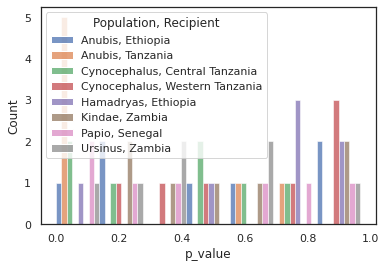

In [37]:
sns.histplot(data=shapiro_wilk, x="p_value", hue="Population, Recipient", multiple="dodge")

In [31]:
ranksums(a_list, x_list)

RanksumsResult(statistic=-1.9639610121239315, pvalue=0.049534613435626706)